In [32]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.inspection import permutation_importance

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction

# Train model for all glaciers, random k-fold cv using annual mass balance


In [45]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_all = data[data['balance_netto'].notna()]
glacier_data_all.reset_index(drop=True, inplace=True)


C:\Users\kasj\AppData\Local\Temp\ipykernel_5828\1510741197.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


### Using the same test glaciers as in "train_model_blocking_by_glacier"

In [46]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2768, 2478, 2769, 3127, 3141]

df_test = glacier_data_all[glacier_data_all['BREID'].isin(test_glaciers)]
# 54 has 37 points
# 703 has 13 points
# 1280 has 25 points
# 2478 has 22 points
# 2769 has 10 points
# 3127 has 60 points
# test has 323 points in total

df_train = glacier_data_all[~glacier_data_all['BREID'].isin(test_glaciers)]

In [4]:
# Run with different random seeds
rand_seed = 25

# Training with random 5-fold cv with temperature and precipitation

In [49]:
# Select features
base_cols = ['altitude','aspect','slope','altitude_climate']
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']
label_cols = ['balance_netto']

In [48]:
# Select features for training
df_train_X = select_variables(df_train, base_cols, temp_cols, prec_cols)

# Select labels for training
df_train_y = select_variables(df_train, label_cols)

X_train, y_train = df_train_X.values, df_train_y.values

In [7]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

### Train model

In [8]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

In [9]:
# Train model
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

In [11]:
#joblib.dump(cv_grid, 'Models/Random_5fold/cv_random_5fold_temp_prec_seed25.pkl')
cv_grid = joblib.load('Models/Random_5fold/cv_random_5fold_temp_prec_seed25.pkl')

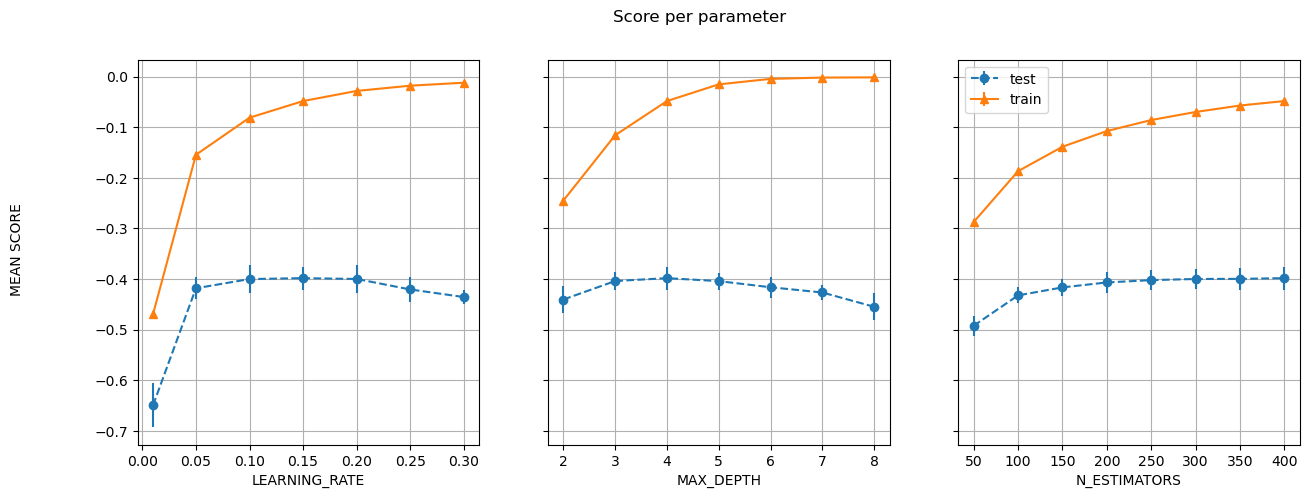

In [12]:
plot_gsearch_results(cv_grid)

In [13]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [15]:
cvl = cross_val_score(fitted_model, X_train, y_train, cv=splits, scoring='neg_mean_squared_error')
print(cvl)

[-0.40122302 -0.40422843 -0.4348377  -0.36638728 -0.38427638]


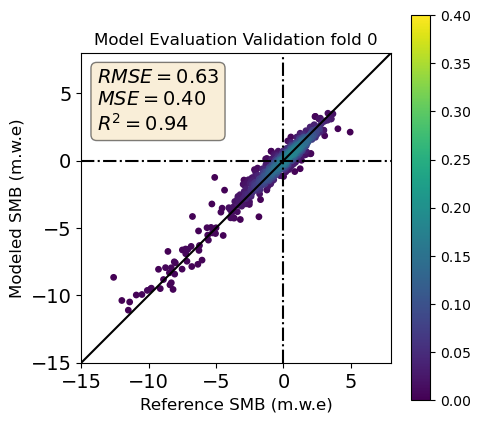

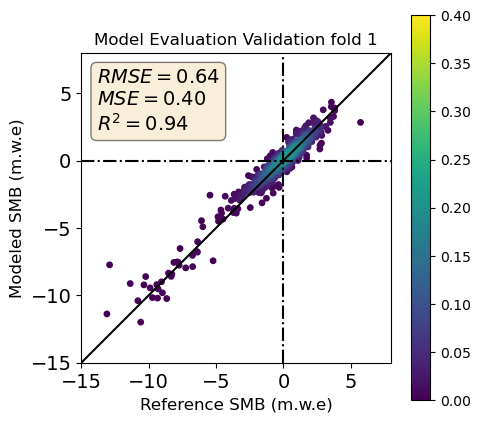

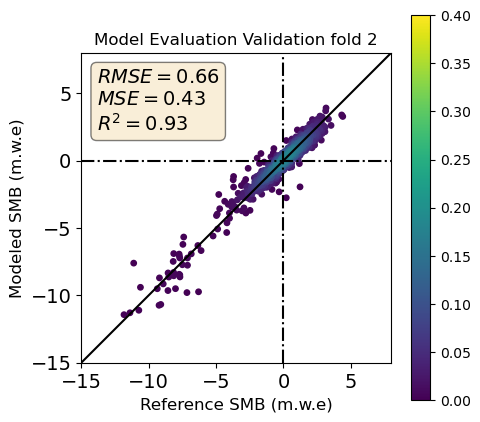

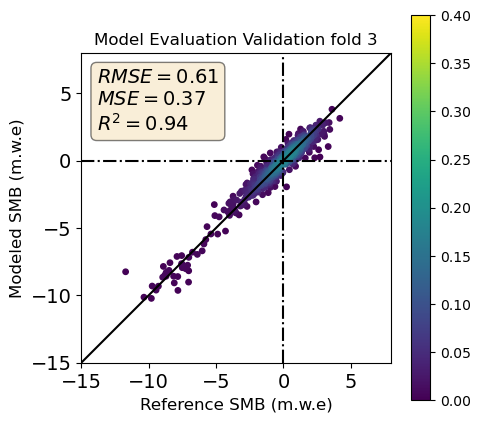

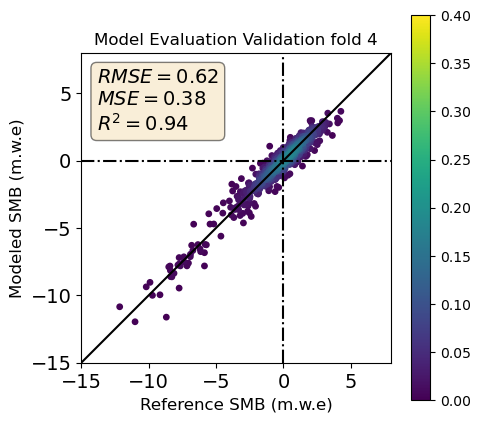

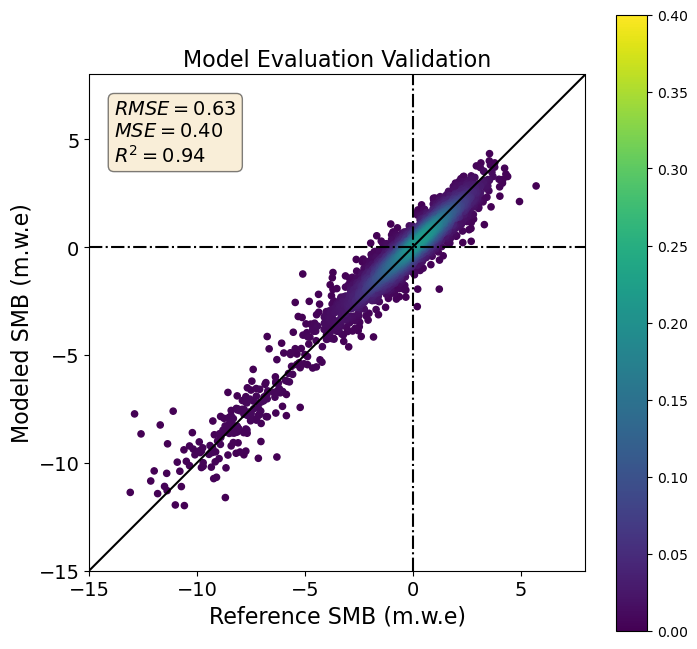

In [16]:
plot_prediction_per_fold(X_train, y_train, fitted_model, splits)

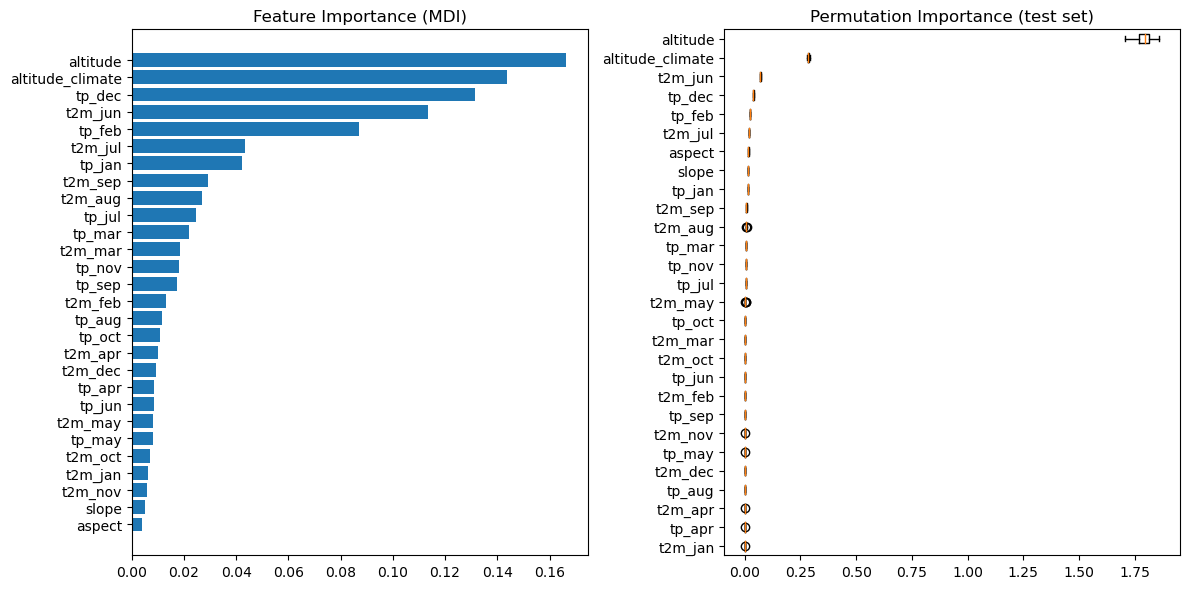

In [13]:
from sklearn.inspection import permutation_importance

best_model.fit(X_train, y_train)
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    best_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_train_X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Training with random 5-fold cv with all climate features

### Select features and prepare data for training

In [18]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation] for y in x]

df_train_X = df_train.drop(drop_cols, axis=1)
df_train_y = df_train[['balance_netto']]

X_train, y_train = df_train_X.values, df_train_y.values

In [30]:
df_train_X

,altitude,aspect,slope,slope_factor,u10_oct,u10_nov,u10_dec,u10_jan,u10_feb,u10_mar,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
189,990.0,2.509464,0.238202,2.365011,0.987576,-0.182683,-0.089565,0.802768,0.236348,-0.376631,...,0.005483,0.003681,0.002447,0.003016,0.001702,0.001953,0.004025,0.002591,0.006047,1001.181943
190,996.0,2.474161,0.117946,3.605711,0.005267,-0.816228,0.717362,1.935894,-0.130982,-0.119557,...,0.012715,0.002994,0.002428,0.001993,0.002906,0.003402,0.003066,0.004062,0.004951,1001.181943
191,988.0,2.509464,0.238202,2.365011,0.603107,-0.514308,-1.539177,-0.466036,-1.326092,-1.272106,...,0.001472,0.000642,0.003090,0.001900,0.003094,0.001567,0.003896,0.004033,0.004845,1001.181943
192,990.0,2.478294,0.146882,3.160964,-0.381773,-0.191252,-2.336107,-0.223529,-0.287798,-0.262661,...,0.003862,0.002945,0.003645,0.003376,0.000861,0.004021,0.006549,0.003302,0.003687,1001.181943
193,990.0,2.478294,0.146882,3.160964,-0.579148,-0.523735,-0.820798,-0.986182,0.486567,0.527984,...,0.001893,0.004887,0.004874,0.004694,0.001514,0.004824,0.003683,0.004470,0.001097,1001.181943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,1151.4,3.229342,0.093474,3.872423,-1.033313,-0.855646,-0.091279,-0.663411,-1.093011,-0.443470,...,0.007993,0.006946,0.009393,0.007489,0.003727,0.008407,0.008133,0.007797,0.006275,903.493549
3834,1196.0,3.752693,0.116894,3.625141,-1.051879,-0.768812,-0.023011,-0.567723,-1.077872,-0.414050,...,0.007843,0.006958,0.009505,0.007355,0.003641,0.008233,0.007808,0.007504,0.006324,1046.032689
3835,1399.5,3.996078,0.040634,3.872423,-1.051879,-0.768812,-0.023011,-0.567723,-1.077872,-0.414050,...,0.007843,0.006958,0.009505,0.007355,0.003641,0.008233,0.007808,0.007504,0.006324,1046.032689
3836,1513.3,3.214424,0.043804,3.872423,-1.051879,-0.768812,-0.023011,-0.567723,-1.077872,-0.414050,...,0.007843,0.006958,0.009505,0.007355,0.003641,0.008233,0.007808,0.007504,0.006324,1046.032689


In [19]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

### Explore folds

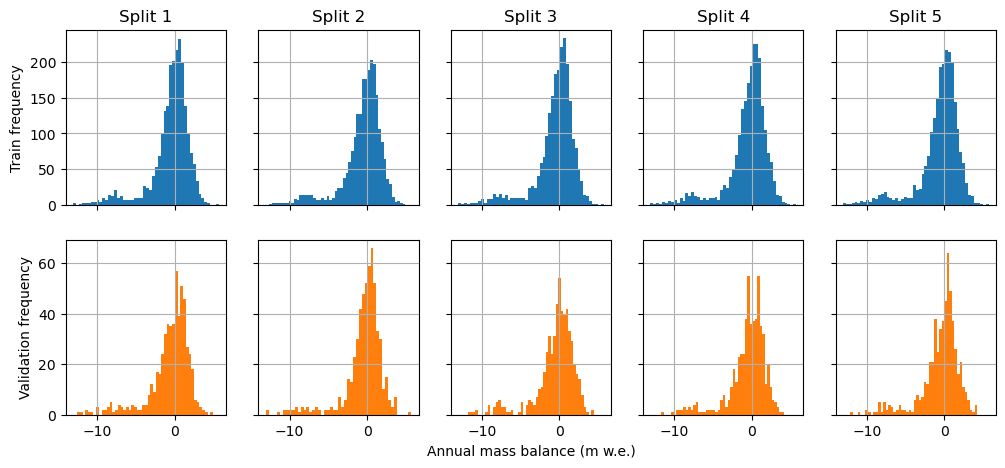

In [20]:
# Plot mass balance distributions of training and validation sets.
j=0
f, ax = plt.subplots(2, len(splits), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits)):
    if i>2:
        j=1
    df_train.iloc[splits[i][0]].balance_netto.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train.iloc[splits[i][1]].balance_netto.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Annual mass balance (m w.e.)')
    
for row in ax:
    for a in row:
        a.grid()

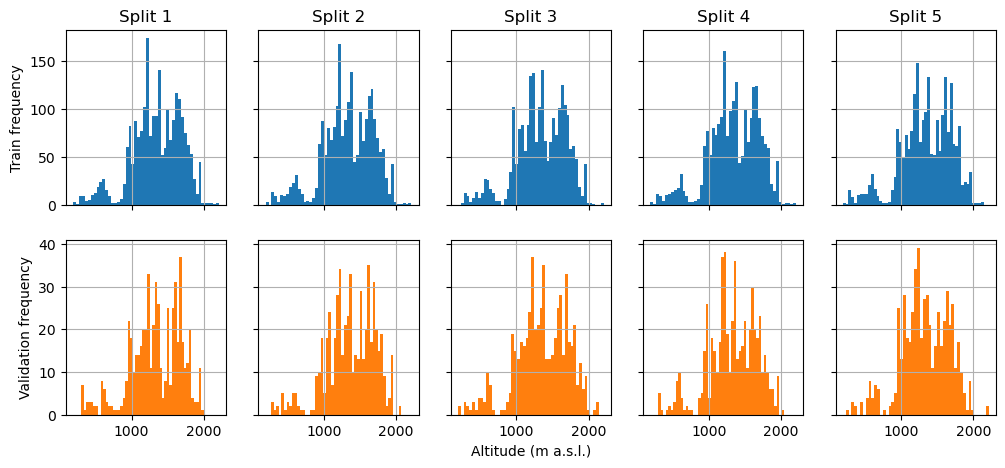

In [21]:
# Plot altitude distributions of training and validation sets.

j=0
f, ax = plt.subplots(2, len(splits), figsize=(12,5), sharey='row', sharex='col')
for i in range(0,len(splits)):
    if i>2:
        j=1
    df_train.iloc[splits[i][0]].altitude.plot.hist(bins=50, ax=ax[0,i], color='C0')
    df_train.iloc[splits[i][1]].altitude.plot.hist(bins=50, ax=ax[1,i], color='C1')
    ax[0,i].set_title('Split '+str(i+1))

ax[0,0].set_ylabel('Train frequency')
ax[1,0].set_ylabel('Validation frequency')
ax[1,2].set_xlabel('Altitude (m a.s.l.)')
    
for row in ax:
    for a in row:
        a.grid()

### Train model

In [23]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

In [24]:
# Train model
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

In [25]:
# Save cv-object
#joblib.dump(cv_grid, 'Models/Random_5fold/cv_random_5fold_all_climate_seed25.pkl')
cv_grid = joblib.load('Models/Random_5fold/cv_random_5fold_all_climate_seed25.pkl')

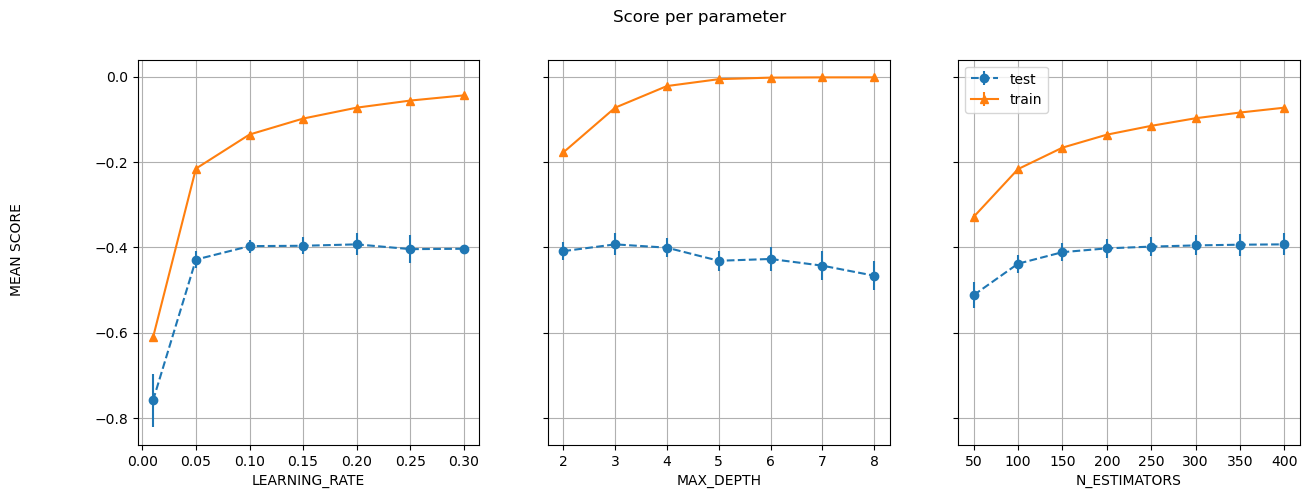

In [26]:
plot_gsearch_results(cv_grid)

In [27]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [28]:
cvl = cross_val_score(fitted_model, X_train, y_train, cv=splits, scoring='neg_mean_squared_error')
print(cvl)

[-0.37777406 -0.43846855 -0.38555264 -0.36192718 -0.40195378]


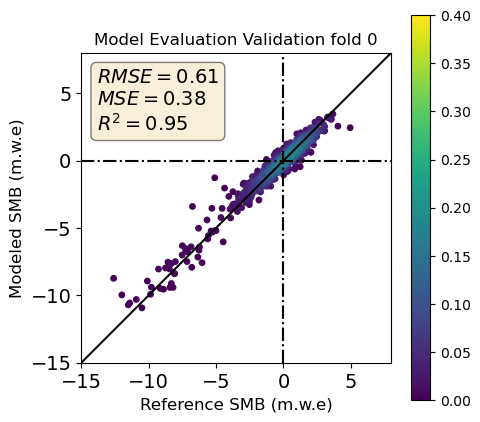

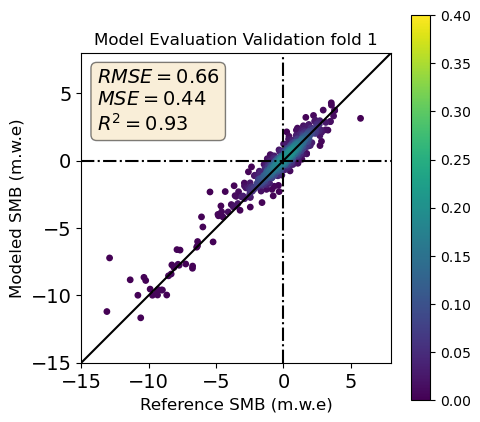

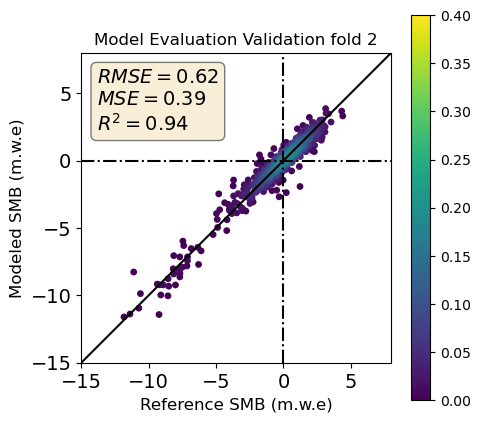

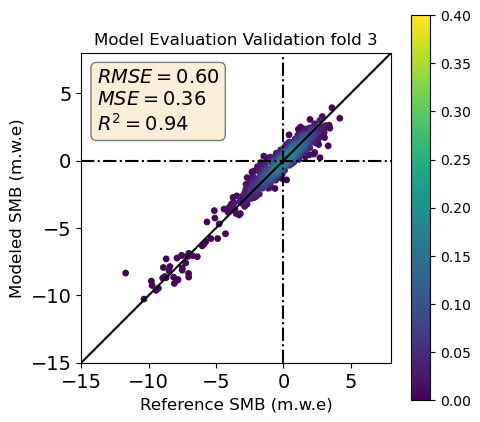

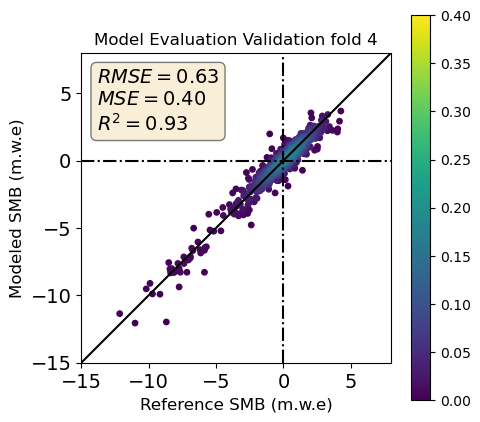

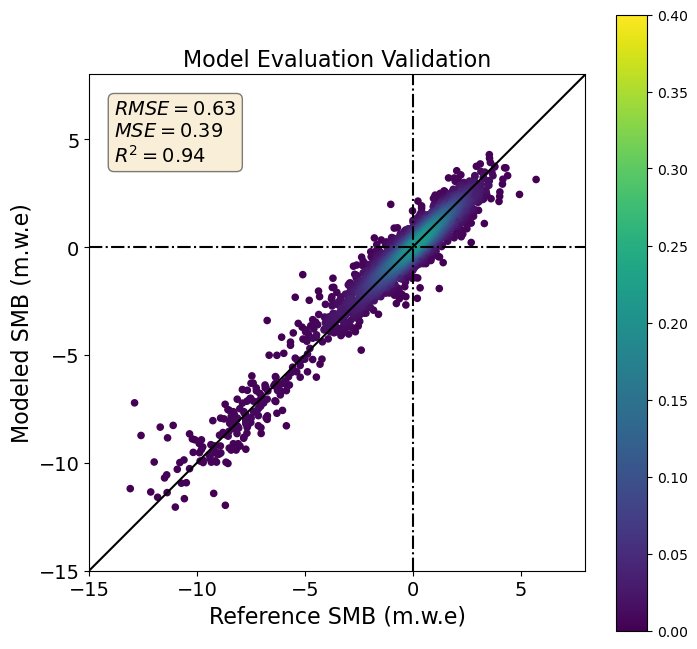

In [29]:
plot_prediction_per_fold(X_train, y_train, fitted_model, splits)

In [22]:
# Plot feature importance

max_features_plot = 50

best_model.fit(X_train, y_train)
feature_importance = best_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X.columns)[ind]

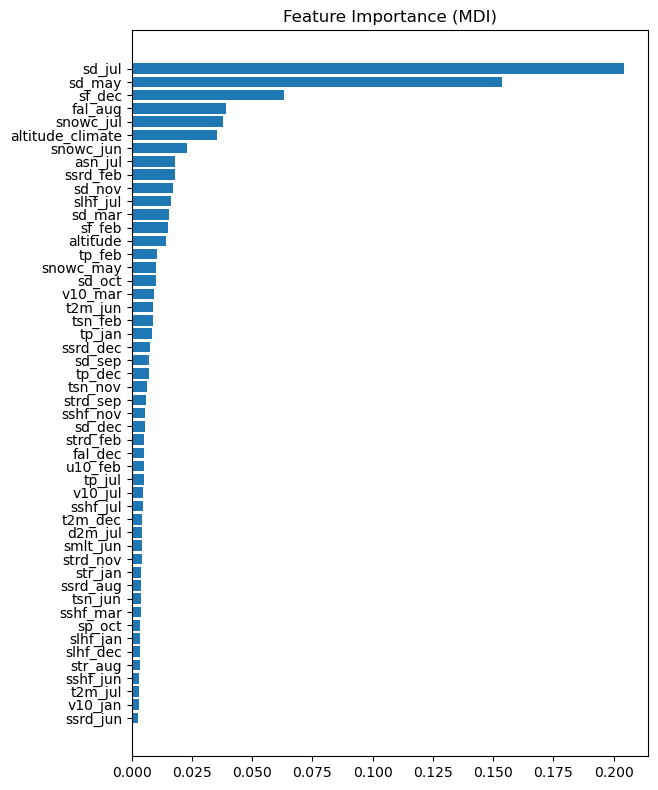

In [23]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Training with random 5-fold cv with minimal climate features (removing derived/redundant features)

### Select features and prepare data for training

In [31]:
# Select columns to drop
cols = ['BREID','RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north',
        'balance_winter','balance_summer','balance_netto','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat','lon','lat_approx','lon_approx',
        'topo','dis_from_border','year']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo] for y in x]

df_train_X = df_train.drop(drop_cols, axis=1)
df_train_y = df_train[['balance_netto']]

X_train, y_train = df_train_X.values, df_train_y.values

In [32]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train, y_train))

### Train model

In [33]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
              'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
              'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]}

In [34]:
# Train model
#cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, scorer='neg_mean_squared_error')

In [35]:
# Save cv-object
#joblib.dump(cv_grid, 'Models/Random_5fold/cv_random_5fold_minimal_climate_seed25.pkl')
cv_gird = joblib.load('Models/Random_5fold/cv_random_5fold_minimal_climate_seed25.pkl')

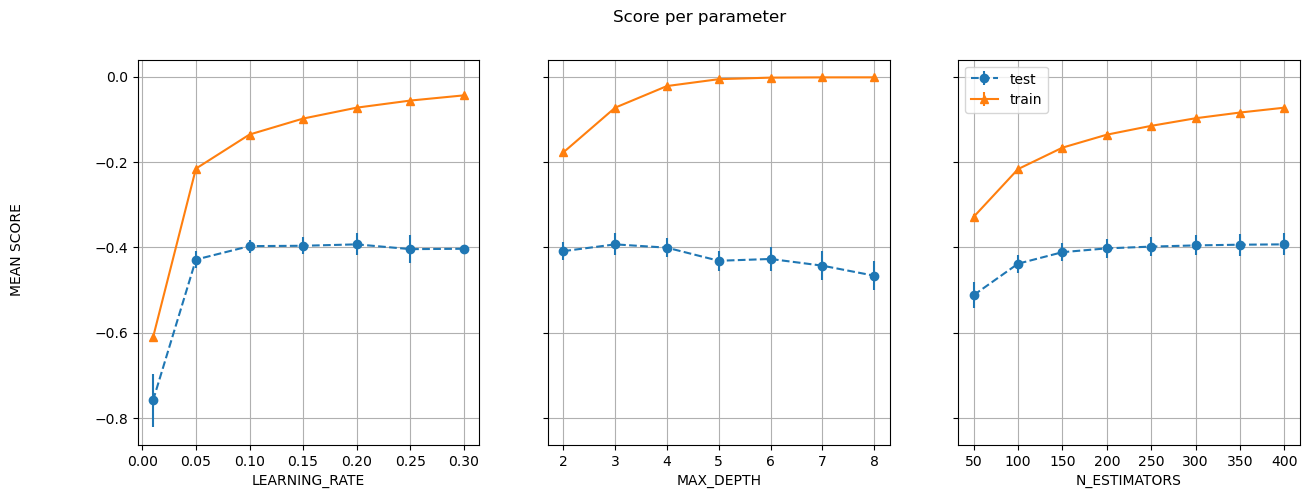

In [36]:
plot_gsearch_results(cv_grid)

In [37]:
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [38]:
cvl = cross_val_score(fitted_model, X_train, y_train, cv=splits, scoring='neg_mean_squared_error')
print(cvl)

[-0.37422756 -0.47188112 -0.41967032 -0.38956275 -0.41471582]


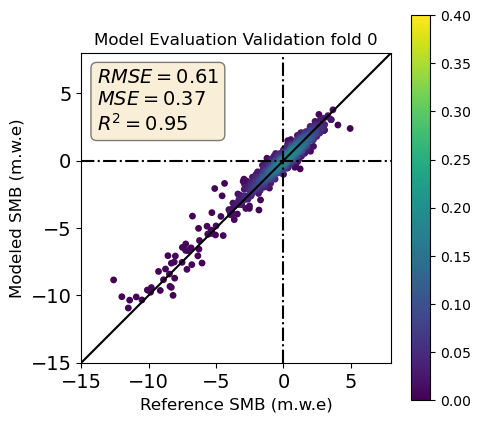

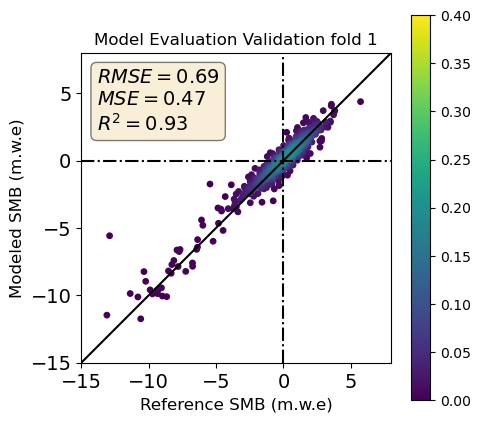

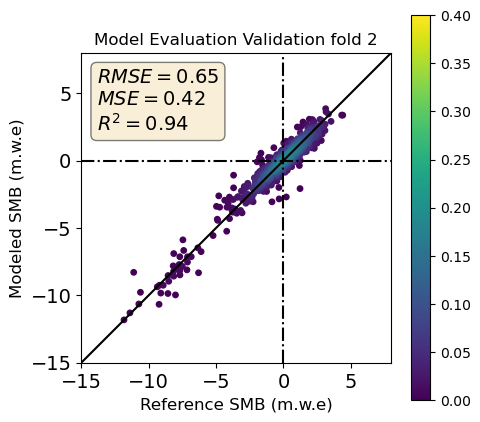

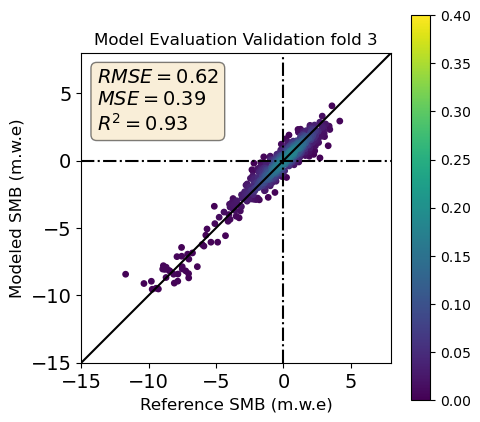

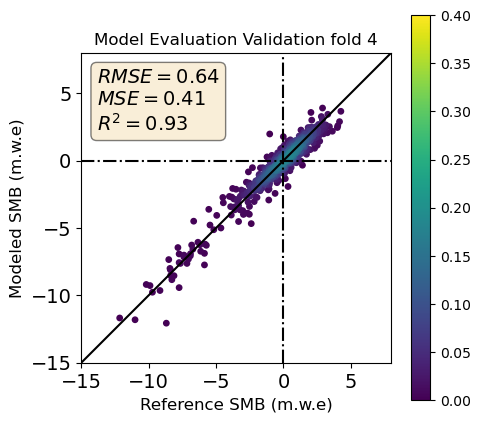

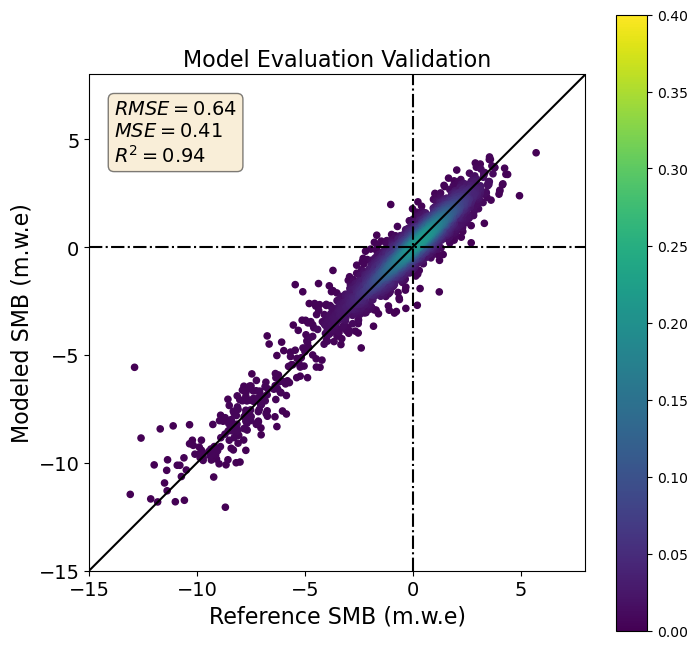

In [39]:
plot_prediction_per_fold(X_train, y_train, fitted_model, splits)

In [42]:
# Plot feature importance

max_features_plot = 50

fitted_model.fit(X_train, y_train)
feature_importance = fitted_model.feature_importances_
ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
feature_importance_50 = feature_importance[ind]
sorted_idx = np.argsort(feature_importance_50)
y_cols = np.array(df_train_X.columns)[ind]

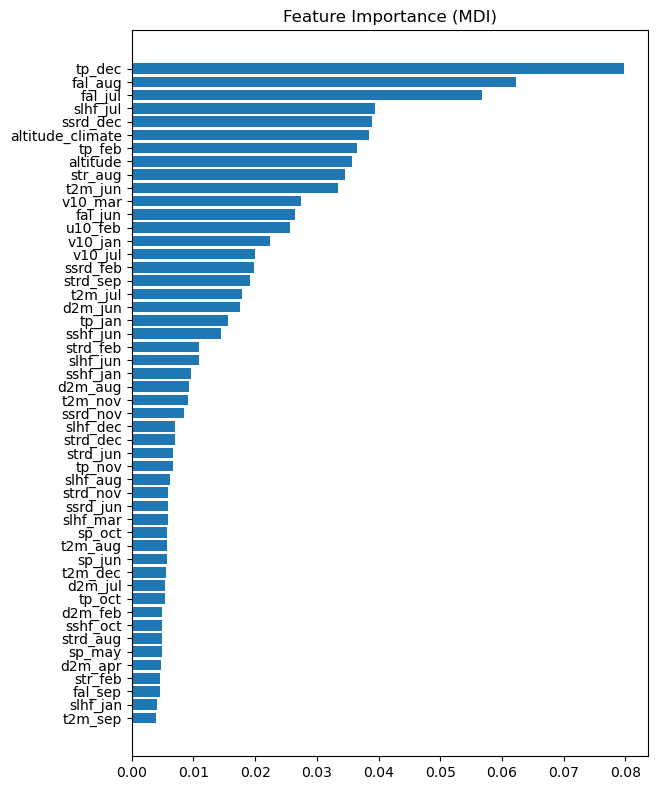

In [43]:
from sklearn.inspection import permutation_importance

#sorted_idx = np.argsort(feature_importance)
#mask = sorted_idx < 50
#sorted_idx = sorted_idx[mask]
pos = np.arange(sorted_idx.shape[0]) + 0.5

#feature_importance
#sorted_idx = np.argsort(feature_importance)
#sorted_idx
#pos = np.arange(sorted_idx.shape[0]) + 0.5
#pos
#t = np.argwhere(sorted_idx<50)
#t
#pos = np.arange(t.shape[0])+0.5

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_50[sorted_idx], align="center")
#plt.barh(pos, feature_importance[t],align='center')
#plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.yticks(pos, y_cols[sorted_idx])
plt.title("Feature Importance (MDI)")

#result = permutation_importance(
#    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
#)
#sorted_idx = result.importances_mean.argsort()
#plt.subplot(1, 2, 2)
#plt.boxplot(
#    result.importances[sorted_idx].T,
#    vert=False,
#    labels=np.array(df_train_X.columns)[sorted_idx],
#)
#plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

ssrd_dec is a proxy for latitude??

# Train model for all glaciers, random k-fold cv using annual and seasonal mass balance

In [2]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_16012\3172944082.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [3]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2320, 2478, 2769, 3127, 3141]

df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3127 has 145 points
# 3141 has 72 points
# Test dataset has 926 points in total, approximately 24% of the data
# Train dataset has 2984 points, approximately 76% of the data

df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

In [4]:
# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6

C:\Users\kasj\AppData\Local\Temp\ipykernel_16012\1628288660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_16012\1628288660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_16012\1628288660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [5]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, dewpt_temp, surface_pressure, sol_rad_down, sol_therm_down] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

In [6]:
# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)

var = ['u10', 'v10', 't2m', 'fal', 'sshf', 'slhf', 'ssr', 'str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan


In [7]:
# Combine the three dataframes
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])


In [27]:
# Select features for training
df_train_X = df_train_all.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y = df_train_all[['balance']]

X_train_s, y_train_s = df_train_X.values, df_train_y.values

In [28]:
# Run with different random seeds
rand_seed = 25

In [29]:
# Use five folds
kf = KFold(n_splits=5, shuffle=True, random_state=rand_seed)
splits = list(kf.split(X_train_s, y_train_s))

In [31]:
X_train.shape

(8912, 114)

In [34]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Cross validation score:  -0.18497175937114924
Grid search best hyperparameters:  {'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 400}
Cross validation scores per fold:  [-0.18952152 -0.15616704 -0.17880931 -0.17979343 -0.22056749]
Mean cross validation score:  -0.18497175937114924
Standard deviation:  0.020891429252272817


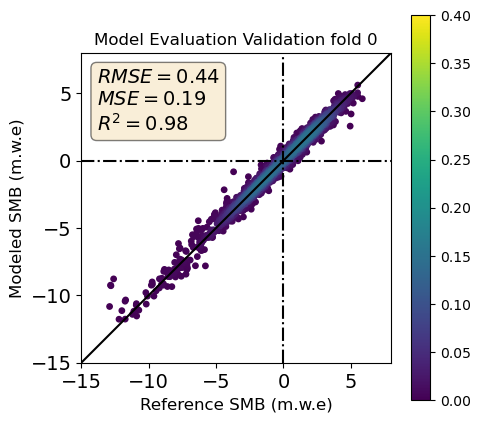

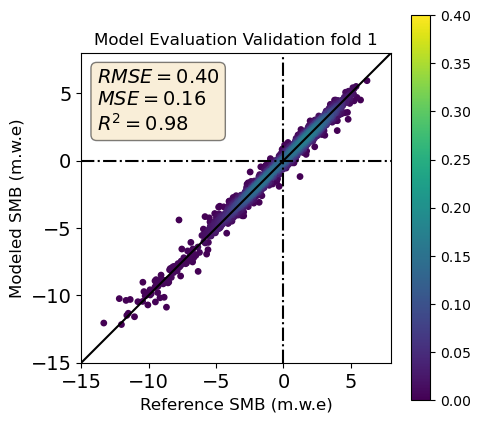

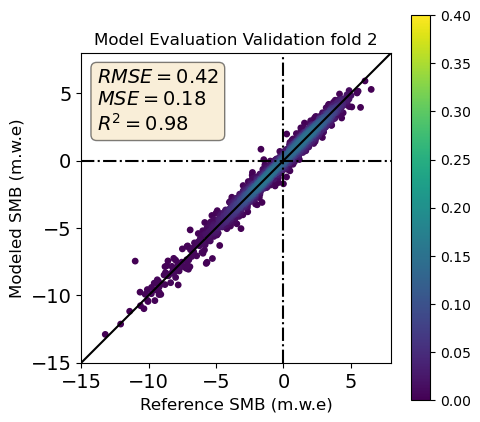

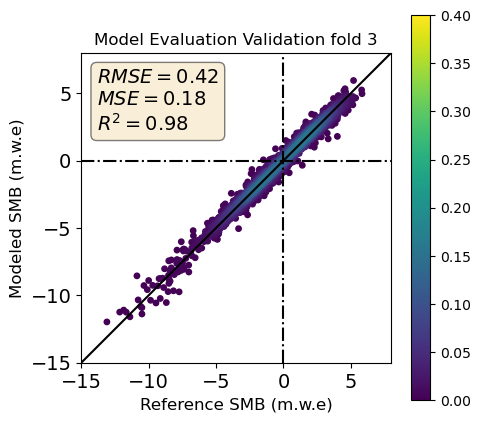

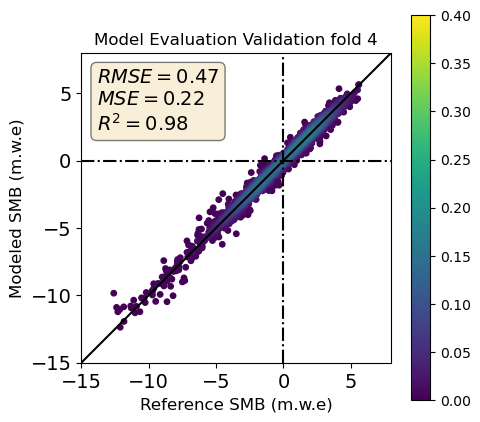

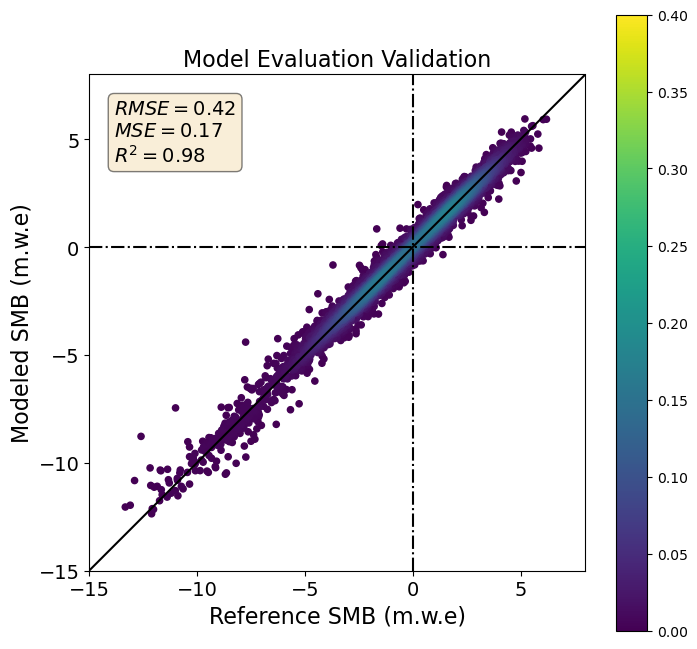

In [35]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train, y_train, splits, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [15]:
cv_grid.best_params

{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 1000}

In [12]:
# Save cv-object
#joblib.dump(cv_grid, 'Models/Random_5fold_ann+seas/cv_random_5fold_minimal_climate_400_trees.pkl')
cv_grid = joblib.load('Models/Random_5fold_ann+seas/cv_random_5fold_minimal_climate_400_trees.pkl')

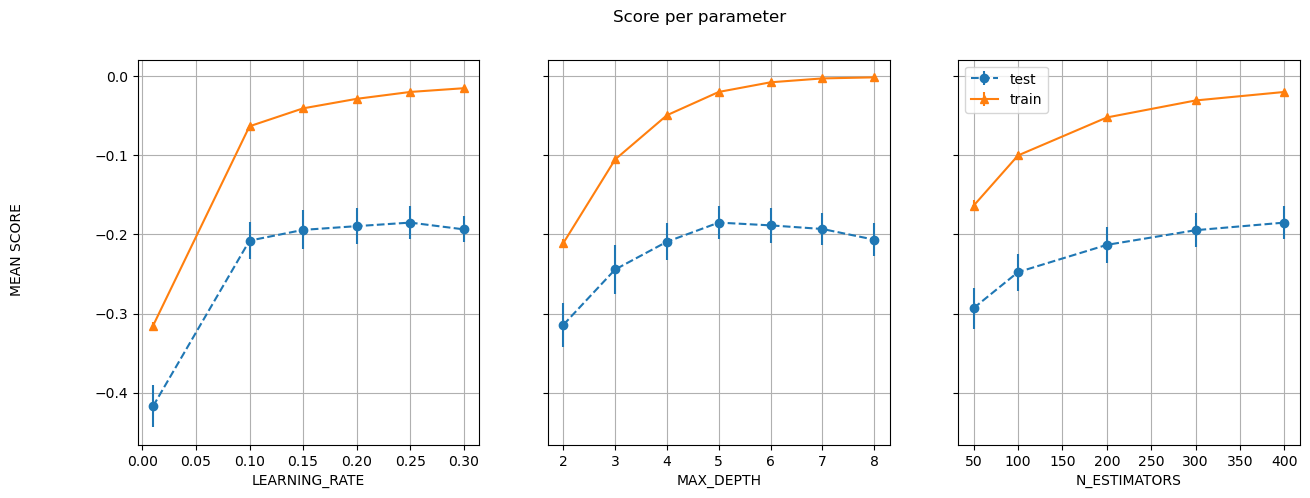

In [13]:
plot_gsearch_results(cv_grid)


In [19]:
best_model = xgb.XGBRegressor(**cv_grid.best_params_)

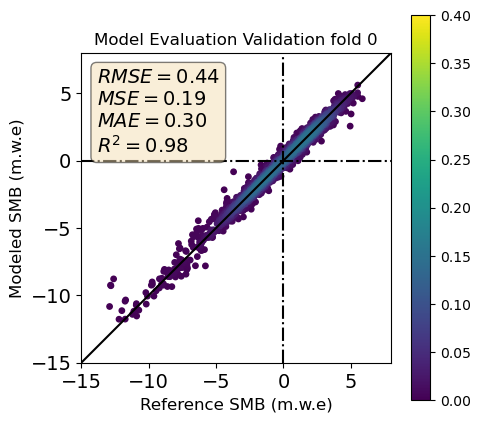

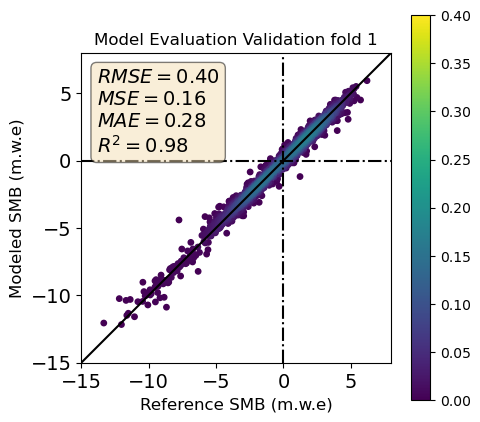

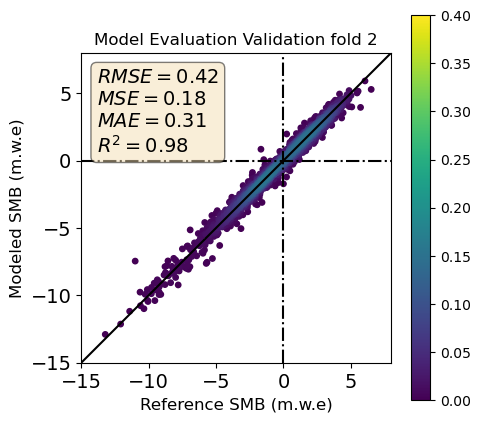

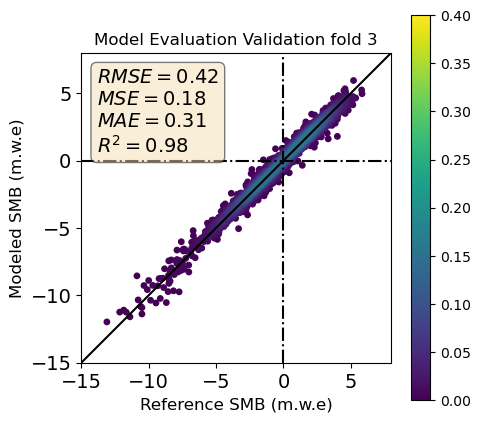

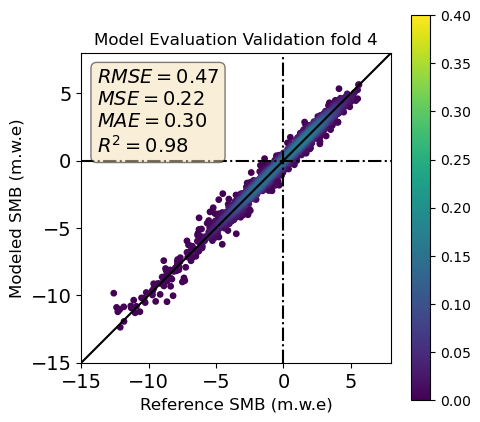

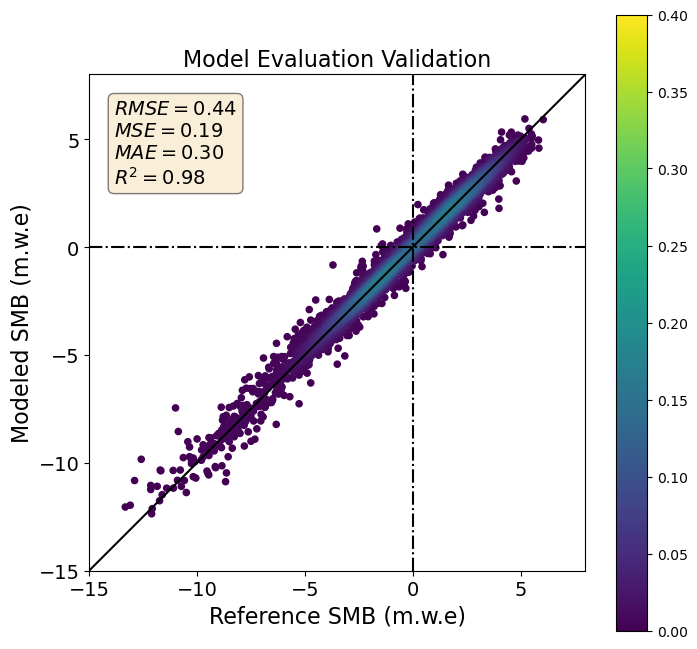

In [16]:
plot_prediction_per_fold(X_train_s, y_train_s, fitted_model, splits)

In [20]:
def plot_prediction_subplot(y1, y2, data_type:str, ax, n_toplot=10**10, fold=False):
    """
    Plot model predictions y1 vs. actual observations y2 and show
    calculated error metrics.

    Parameters:
    y1 : np.array
        Predicted labels.
    y2 : np.array
        Actual labels.
    data_type : str
        Type of data, e.g. "Validation" or "Test".
    ax : array
        Axis object
    n_toplot : int
        Number of points to plot. 
    """
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error

    if fold:
        figsize=(5,5)
        fontsize=12
        s= 15
    else:
        figsize=(8,8)
        fontsize=16
        s= 20
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    #fig = plt.figure(figsize=figsize)
    sc = ax.scatter(y_plt, ann_plt, c=z, s=s)
    sc.set_clim(0,0.2)
    #plt.tick_params(labelsize=14)
    plt.colorbar(sc,ax=ax,fraction=0.046) 
    lineStart = y_min
    lineEnd = y_max
    ax.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    ax.set_title("Model Evaluation " + data_type, fontsize=fontsize)
    ax.set_ylabel('Modeled SMB (m.w.e)', fontsize=fontsize)
    ax.set_xlabel('Reference SMB (m.w.e)', fontsize=fontsize)
    ax.axvline(0.0, ls='-.', c='k')
    ax.axhline(0.0, ls='-.', c='k')
    ax.set_xlim(lineStart, lineEnd)
    ax.set_ylim(lineStart, lineEnd)
    ax.set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=False), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=True), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return ax
    #plt.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_16012\2673047429.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


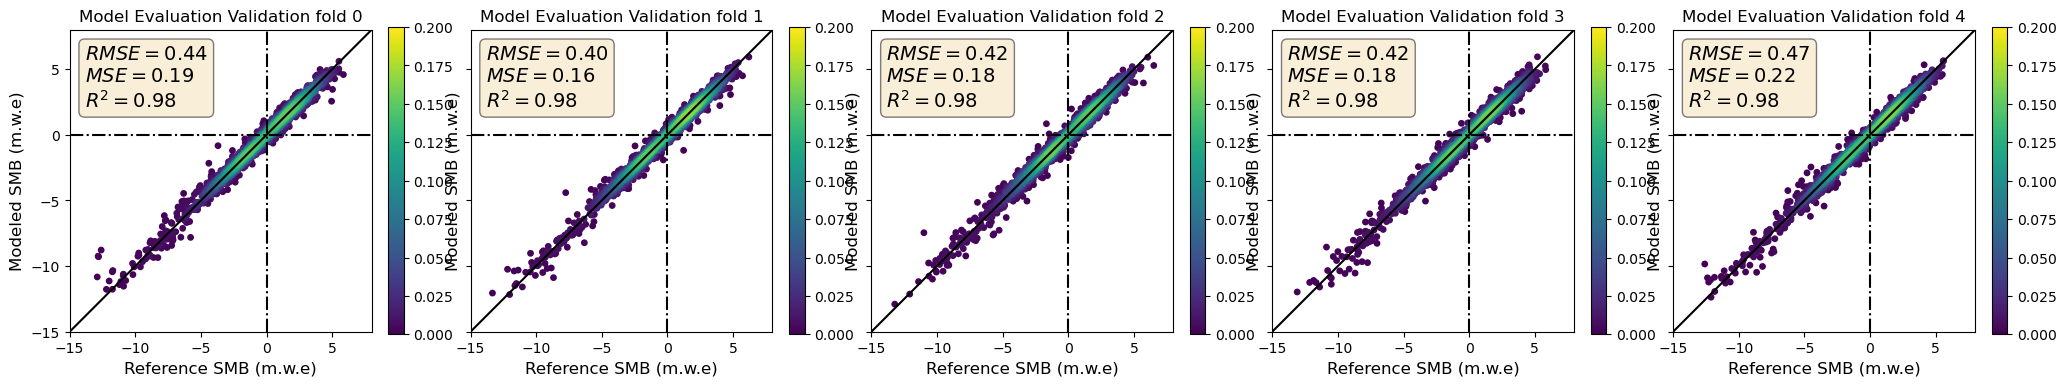

In [30]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(a)

    plot_prediction_subplot(y_test, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

fig.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_16012\3584257457.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


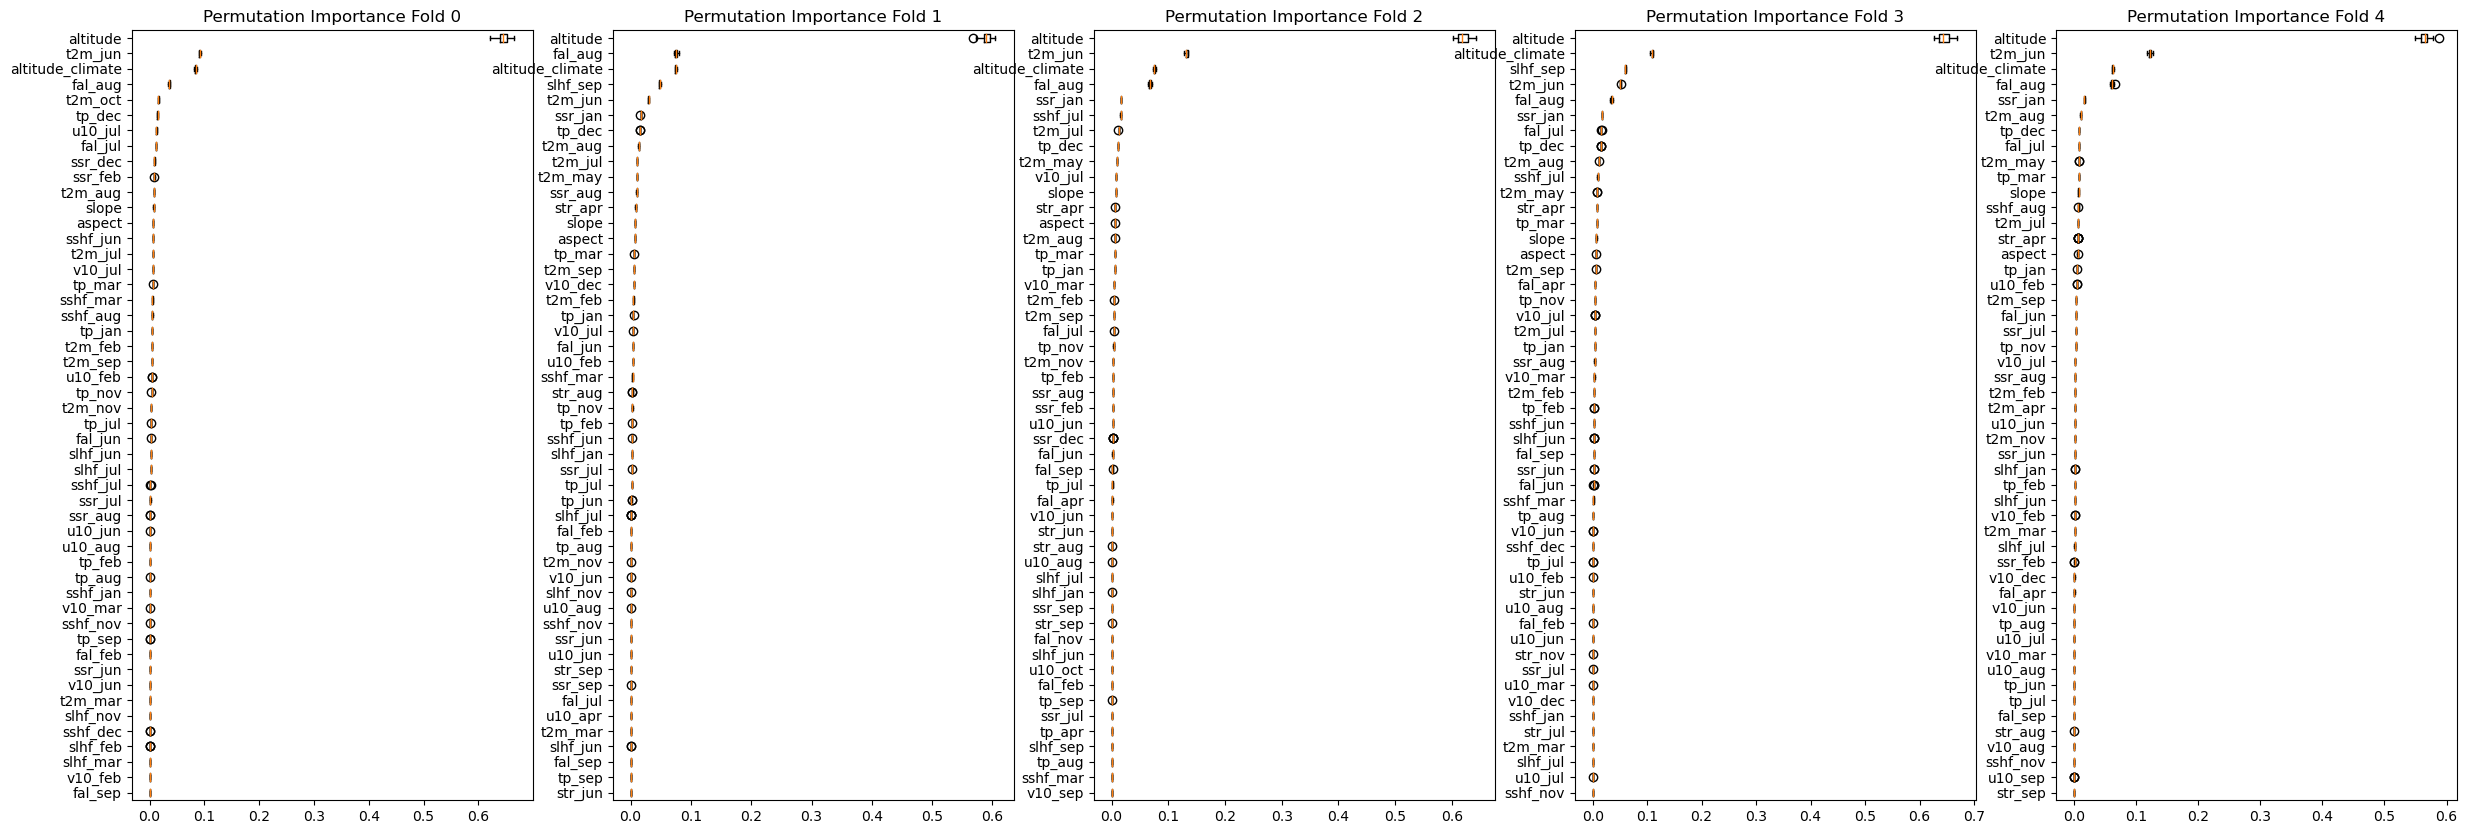

In [33]:
# Plot permutation importance

max_features_plot = 50

fig, ax = plt.subplots(1,5, figsize=(30,10))
a = 0    
for train_index, test_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]

    best_model.fit(X_train, y_train)
    
    result = permutation_importance(best_model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=10)

    sorted_idx = result.importances_mean.argsort()
    labels = np.array(df_train_X.columns)[sorted_idx][-max_features_plot:]
    
    ax[a].boxplot(result.importances[sorted_idx].T[:,-max_features_plot:], vert=False, labels=labels)
    ax[a].set_title("Permutation Importance Fold " + str(a))

    a=a+1

fig.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_16012\2452797748.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


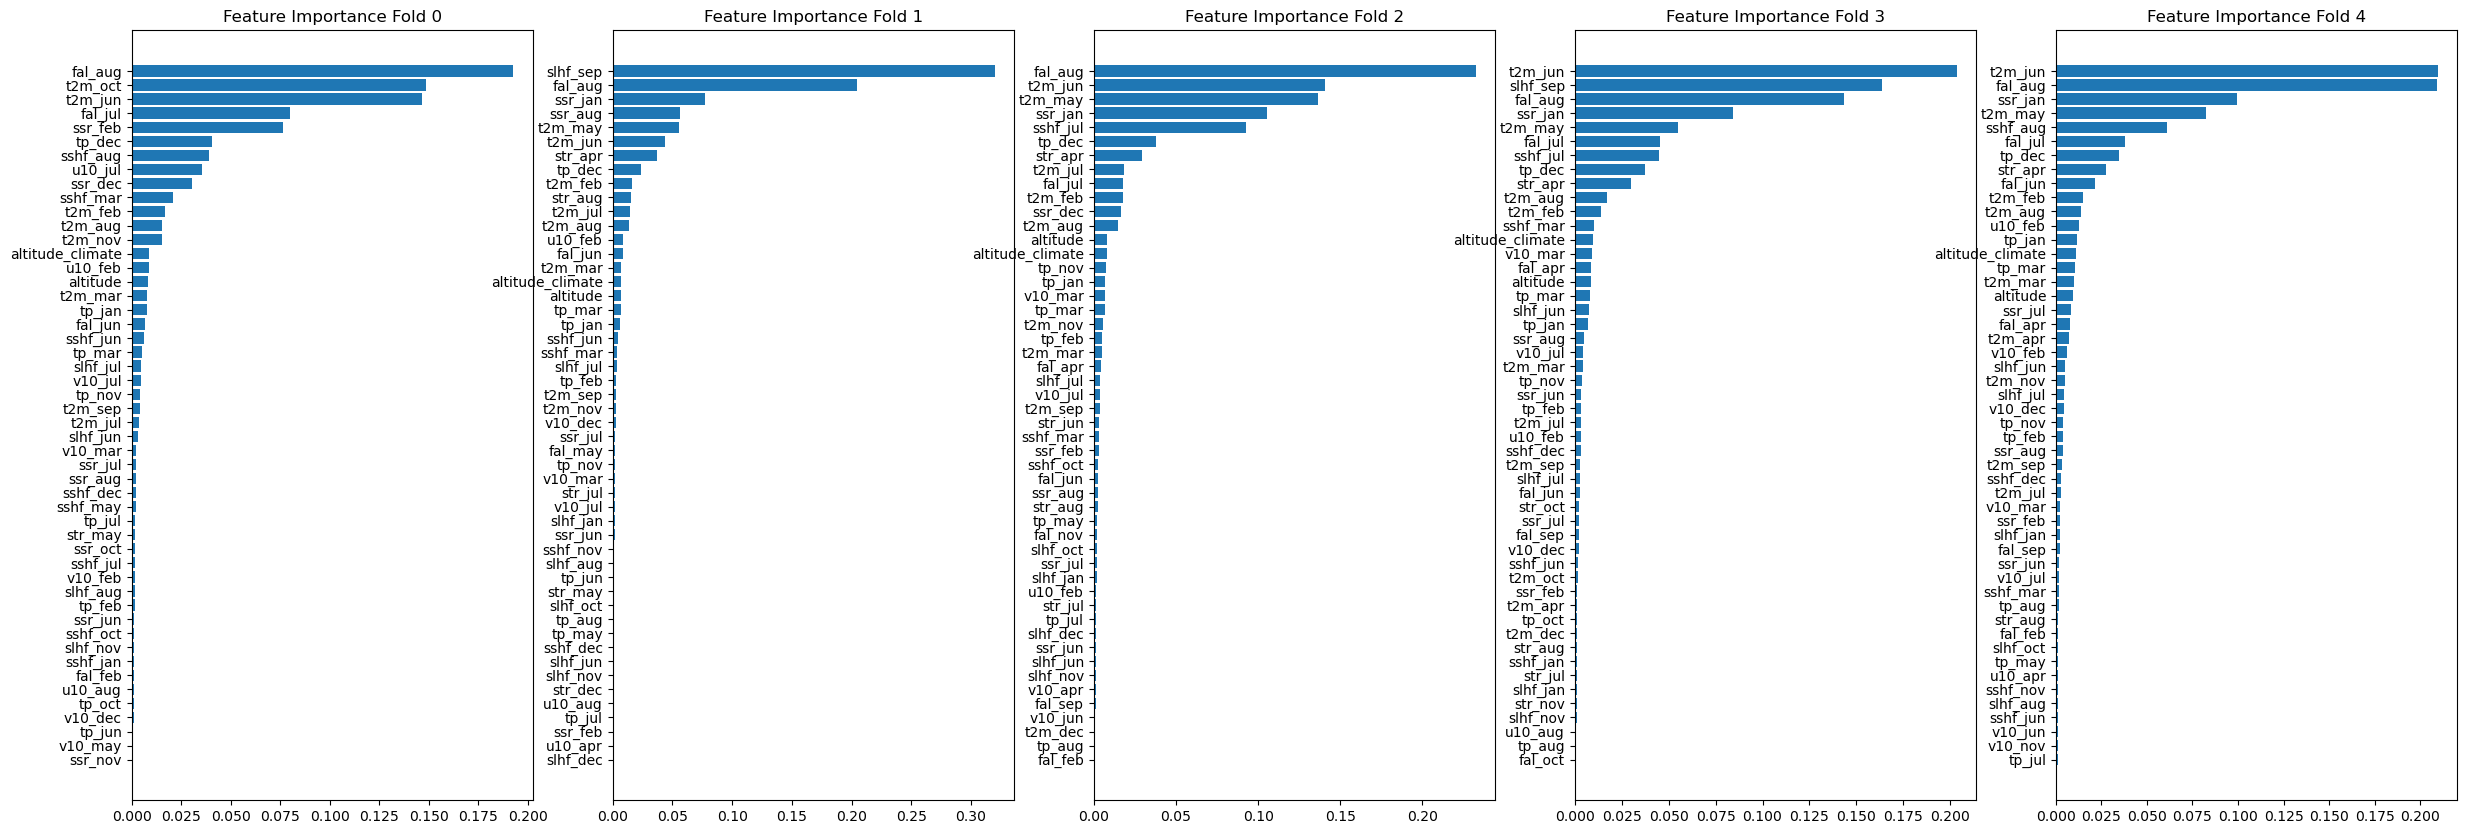

In [36]:
max_features_plot = 50

fig, ax = plt.subplots(1,5, figsize=(30,10))
a = 0    
for train_index, test_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    
    best_model.fit(X_train, y_train)
    feature_importance = best_model.feature_importances_
    ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
    feature_importance_50 = feature_importance[ind]
    sorted_idx = np.argsort(feature_importance_50)
    y_cols = np.array(df_train_X.columns)[ind]

    pos = np.arange(sorted_idx.shape[0]) + 0.5

    ax[a].barh(pos, feature_importance_50[sorted_idx], align="center")
    ax[a].set_yticks(pos)
    ax[a].set_yticklabels(y_cols[sorted_idx])
    ax[a].set_title("Feature Importance Fold " + str(a))

    a=a+1

fig.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_16012\3041986245.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


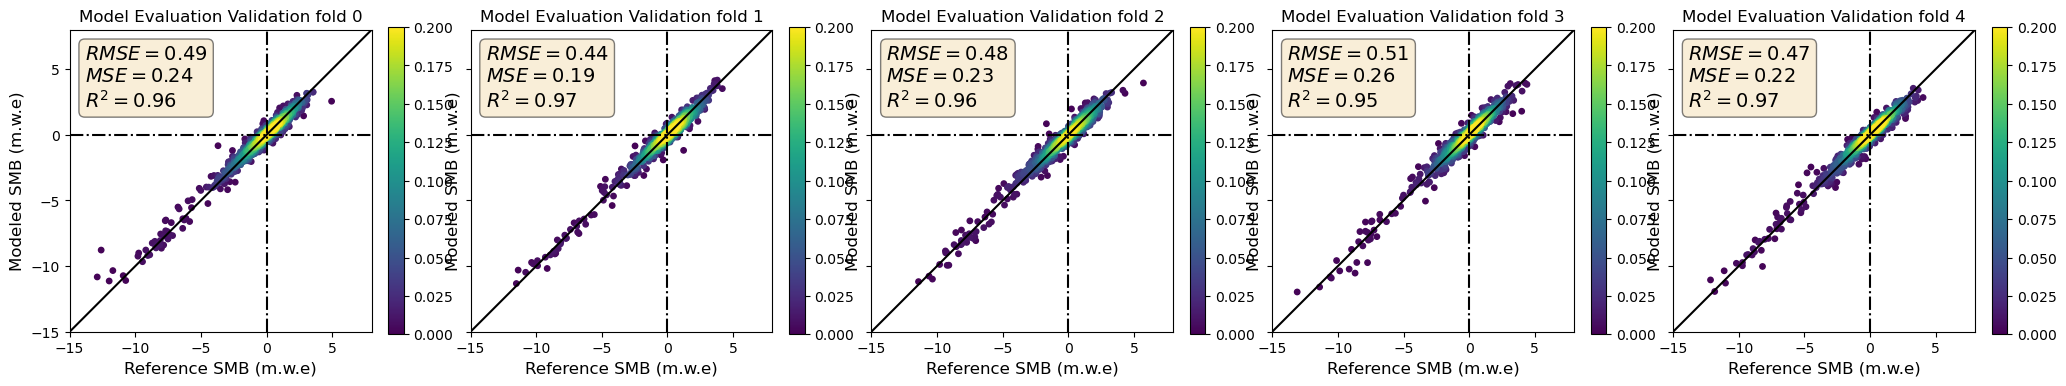

In [38]:
# Plot each of annual, winter and summer separately
months=12

fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(a)

    indices = np.argwhere((X_test == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    plot_prediction_subplot(y_test_crop, y_pred_crop, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

fig.show()

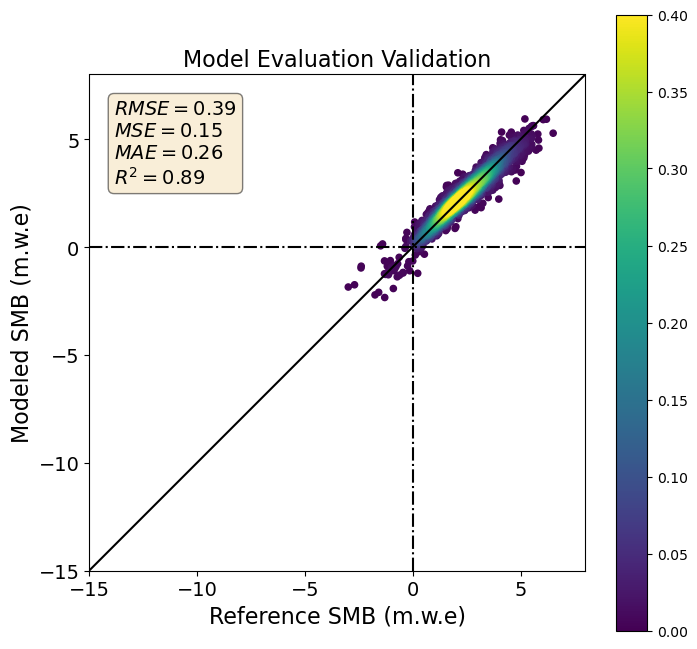

C:\Users\kasj\AppData\Local\Temp\ipykernel_16012\2084444895.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [41]:
# Plot each annual, winter, summer separately in one plot

months = 8
y_pred_list = []
y_test_list = []
i=0

for train_index, test_index in splits:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation'

    indices = np.argwhere((X_test == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    y_test_list.extend(y_test_crop)
    y_pred_list.extend(y_pred_crop)


    i=i+1

# Arrays of predictions and observations for each fold
y_test_all = np.hstack([*y_test_list])
y_pred_all = np.hstack([*y_pred_list])

plot_prediction(y_test_all, y_pred_all, title, n_toplot=5000, fold=False)

fig.show()